### Model Evaluation
Chase Kent-Dotson  
April 4, 2022

### Introduction
This notebook begins with evaluation of the model's predictions on the test set, moving along to examine missclassifications in more depth, and finally by re-evaluating the model using new labels. 

### Table of Contents:
* [Initial View of Predictions by Class](#1)
* [Observing False Positives Among the Least Precise Classes](#2)
* [Re-scoring the Model by Make](#3)
* [Further Evaluation of the Make-Class Model Predictions](#4)
* [Type Label Data Cleaning](#5)
* [Evaluation of Type-Class Model Predictions](#6)
* [Conclusion](#7)

### Imports

In [2]:
# data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# image file handling
from PIL import Image
import cv2

# file directory interface
import os.path, sys

# transfer learning modeling
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras import Model
import efficientnet.tfkeras as efn

# model evaluation
from sklearn.metrics import classification_report

# data generation for modeling
from keras.preprocessing.image import ImageDataGenerator

### Initial View of Predictions by Class <a class="anchor" id="1"></a>
Below I will get an initial view of the predictions by class using the best model's predictions on the test set and the classification report showing evaluation metrics for each class.

In [8]:
# Data agumentation function
def augment_data(img_size, batch_size=32, num_classes=196):
    '''
    Prepares all data generators for train, validation, and test data
    
    Parameters
    ----------
    img_size: tuple designating image resolution, use (224,224) for EfficientNetB0
    batch_size: the number of images to be processed and trained at once, default 32
    num_classes: the number of classes in the data, default 196 for this dataset
    
    Returns
    -------
    ret: a tuple containing the following:
        train_datagen: the data generator for the train set
        test_datagen: the data generator for the test set
        train_data: the flow from directory call for retrieving train images
        validation_data: the flow from directory call for retrieving validation images
        test_data: the flow from directory call for retrieving test images
    
    '''
    
    # assert types for all parameters
    assert isinstance(img_size, tuple), 'img_size must be a tuple'   
    assert isinstance(batch_size, int), 'batch_size must be an integer'   
    assert isinstance(num_classes, int), 'num_classes must be an integer' 
    
    # data generator with a 1/255 rescale, +-20% random shear and zoom, and a random binary flip
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       samplewise_std_normalization=True,
                                       samplewise_center=True,
                                       validation_split=0.2)

    # no random augmentations to the test data
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      samplewise_std_normalization=True,
                                      samplewise_center=True)

    # generate the data for the train set including automatic labels from file structure
    train_data = train_datagen.flow_from_directory('data/car_data/car_data/train',
                                                  target_size=img_size,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='training')

    # generate the validation data from the portion set aside earlier
    validation_data = train_datagen.flow_from_directory('data/car_data/car_data/train',
                                                        target_size=img_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation') 

    # generate data for the test set
    test_data = test_datagen.flow_from_directory('data/car_data/car_data/test',
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)
    
    return (train_datagen, test_datagen, train_data, validation_data, test_data)

In [4]:
# load model
model = keras.models.load_model('models/transfer_model_B0_fine_tune_20_epoch')

In [5]:
# set variables for data preparation and augmentation
img_size = (224,224)
batch_size = 32
num_classes = 196

In [9]:
# call the data augmentation funtion to prepare the images
train_datagen, test_datagen, train_data, validation_data, test_data = augment_data(img_size)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [11]:
# make predictions on the test data and save them
pred = model.predict(test_data, verbose=1)

# get a list of the hard predictions
predicted = np.argmax(pred, axis=1)

252/252 [==============================] - 198s 778ms/step


In [12]:
# get the class names from the test data generator
names = test_data.class_indices.keys()

# generate the classification report 
report = classification_report(test_data.classes, predicted, target_names=names)

# view the report
print(report)

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.93      0.93      0.93        44
                             Acura Integra Type R 2001       0.89      0.77      0.83        44
                                   Acura RL Sedan 2012       0.62      0.56      0.59        32
                                   Acura TL Sedan 2012       0.83      0.79      0.81        43
                                  Acura TL Type-S 2008       0.76      0.69      0.72        42
                                  Acura TSX Sedan 2012       0.93      0.68      0.78        40
                              Acura ZDX Hatchback 2012       0.96      0.67      0.79        39
              Aston Martin V8 Vantage Convertible 2012       0.48      0.67      0.56        45
                    Aston Martin V8 Vantage Coupe 2012       0.61      0.61      0.61        41
                  Aston Martin Virage C

In [13]:
# put the classification report into a dataframe
report = classification_report(test_data.classes, predicted, target_names=names, output_dict=True)
class_report_df = pd.DataFrame(report).transpose()

In [14]:
# The dataframe contains the accuracy, macro average, and weighted average as rows
# they need to be dropped so they are not mixed in with the class data
class_report_df.drop('weighted avg', inplace=True)
class_report_df.drop('macro avg', inplace=True)
class_report_df.drop('accuracy', inplace=True)

In [125]:
# print the top ten classes by precision score
class_report_df.sort_values(by=['precision'], ascending=False).head(10).reset_index()

,index,precision,recall,f1-score,support
0,Lamborghini Diablo Coupe 2001,1.000000,0.886364,0.939759,44.0
1,Jeep Wrangler SUV 2012,1.000000,0.930233,0.963855,43.0
2,Volvo 240 Sedan 1993,0.976190,0.911111,0.942529,45.0
3,Nissan Leaf Hatchback 2012,0.974359,0.904762,0.938272,42.0
4,Chevrolet HHR SS 2010,0.971429,0.944444,0.957746,36.0
5,Nissan NV Passenger Van 2012,0.971429,0.894737,0.931507,38.0
6,MINI Cooper Roadster Convertible 2012,0.971429,0.944444,0.957746,36.0
7,Hyundai Santa Fe SUV 2012,0.970588,0.785714,0.868421,42.0
8,smart fortwo Convertible 2012,0.970588,0.825000,0.891892,40.0
9,Lamborghini Gallardo LP 570-4 Superleggera 2012,0.969697,0.914286,0.941176,35.0


In [126]:
# print the bottom ten classes by precision score
class_report_df.sort_values(by=['precision']).head(10).reset_index()

,index,precision,recall,f1-score,support
0,Audi S4 Sedan 2012,0.277778,0.512821,0.360360,39.0
1,Audi S5 Coupe 2012,0.326531,0.380952,0.351648,42.0
2,Chevrolet Express Van 2007,0.409091,0.257143,0.315789,35.0
3,Aston Martin V8 Vantage Convertible 2012,0.483871,0.666667,0.560748,45.0
4,Mitsubishi Lancer Sedan 2012,0.494118,0.893617,0.636364,47.0
5,Chevrolet Silverado 1500 Extended Cab 2012,0.500000,0.697674,0.582524,43.0
6,Audi TT Hatchback 2011,0.500000,0.525000,0.512195,40.0
7,Chevrolet Express Cargo Van 2007,0.517241,0.517241,0.517241,29.0
8,Audi S4 Sedan 2007,0.531915,0.555556,0.543478,45.0
9,Chevrolet Silverado 2500HD Regular Cab 2012,0.545455,0.473684,0.507042,38.0


In [163]:
# create a dataframe for visualization
low_p = class_report_df.sort_values(by=['precision']).head(10).reset_index().iloc[0:3]
high_p = class_report_df.sort_values(by=['precision'], ascending=False).head(10).reset_index().iloc[0:3]

visual_df = pd.concat([low_p, high_p], ignore_index=True).sort_values(by=['precision'])
visual_df = visual_df.round(decimals=2)

In [170]:
# set up a custom legend for the combined dataframe values
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Low Precision',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='s', color='w', label='High Precision',
                          markerfacecolor='royalblue', markersize=15)]

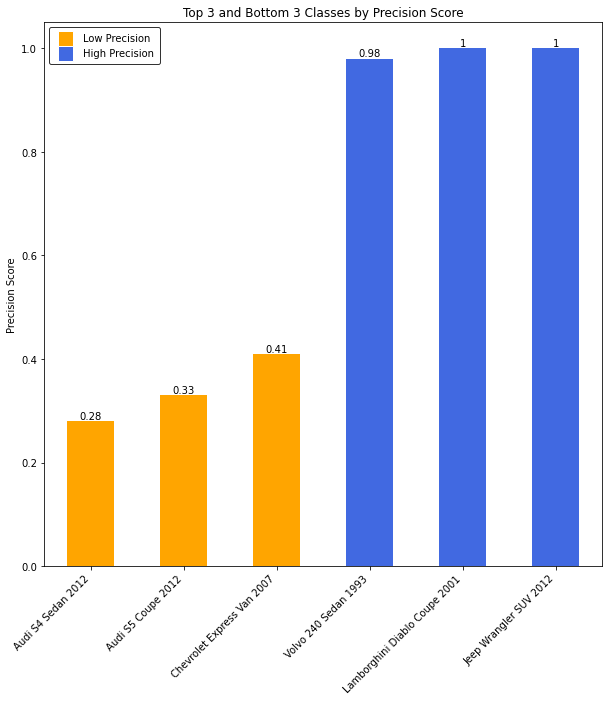

In [172]:
# set up a list to split the colors between high and low precision
color_list = ['orange','orange','orange','royalblue','royalblue','royalblue']

# plot the precision scores
ax = visual_df.plot.bar(x='index', y='precision', figsize=(10, 10), legend=False, color=color_list)
plt.title('Top 3 and Bottom 3 Classes by Precision Score')
plt.ylabel('Precision Score')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
ax.bar_label(ax.containers[0])
plt.legend(handles=legend_elements, edgecolor = 'black', borderpad = 0.6)

# save the image for presentation
plt.savefig('report_pics/precision_by_class.tif', bbox_inches = "tight", dpi=300)

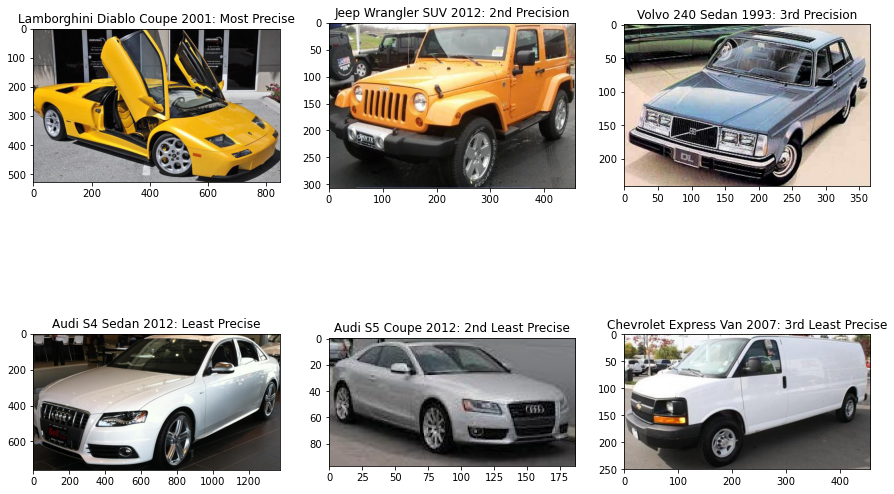

In [28]:
# visualize class distribution data
plt.subplots(2,3, figsize=(15,10))

# number 1 most precise class
plt.subplot(2, 3, 1)
image = plt.imread("data/car_data/car_data/test/Lamborghini Diablo Coupe 2001/00240.jpg")
plt.title('Lamborghini Diablo Coupe 2001: Most Precise')
plt.imshow(image)

# number 2 most precise class
plt.subplot(2, 3, 2)
image = plt.imread("data/car_data/car_data/test/Jeep Wrangler SUV 2012/00092.jpg")
plt.title('Jeep Wrangler SUV 2012: 2nd Precision')
plt.imshow(image)

# number 3 most precise class
plt.subplot(2, 3, 3)
image = plt.imread("data/car_data/car_data/test/Volvo 240 Sedan 1993/03071.jpg")
plt.title('Volvo 240 Sedan 1993: 3rd Precision')
plt.imshow(image)

# number 1 least precise class
plt.subplot(2, 3, 4)
image = plt.imread("data/car_data/car_data/test/Audi S4 Sedan 2012/00604.jpg")
plt.title('Audi S4 Sedan 2012: Least Precise')
plt.imshow(image)

# number 2 least precise class
plt.subplot(2, 3, 5)
image = plt.imread("data/car_data/car_data/test/Audi S5 Coupe 2012/01979.jpg")
plt.title('Audi S5 Coupe 2012: 2nd Least Precise')
plt.imshow(image)

# number 2 least precise class
plt.subplot(2, 3, 6)
image = plt.imread("data/car_data/car_data/test/Chevrolet Express Van 2007/04008.jpg")
plt.title('Chevrolet Express Van 2007: 3rd Least Precise')
plt.imshow(image)

plt.show()

### Initial View of Predictions by Class: Findings
First I'd like to highlight my reasoning for focusing on precision over recall. The stakes are not high in either direction (false positives versus false negatives) when evaluating cars, if used for marketing data as I have proposed and not more serious cases such as law enforcement. As such, for mass car producers, it is more important that identification of cars be as precise as possible for creating cleaner targeted marketing data, such as approximating the total portion of car population a certain model represents in a given area. Recall might become more important when focusing on identification of specialty makes like Ferrari, with so few sightings it would be necessary to be sure that as many as possible are identified when seen by a car camera, and with so few positives generated the predictions could even be verified manually to eliminate false positives from the data. In summary, for collecting data on common cars, my proposed use case, precision is preferred. For uncommon vehicle types, recall may be preferred.  
  
Examining the test set predictions lead to some interesting discoveries about the nature of the model's mistakes and successful predictions. An example image from the test set of each of the top 3 classes and bottom 3 classes by precision score are displayed above, with their precision scores visualized above as well in the bar graph. Classes predicted with the highest precision have boxy shapes and unique features, like the Volvo 240 Sedan 1993, while classes predicted with the lowest precision have rounded shapes and generic features, like the Chevrolet Express Van 2007.  
  
Upon examinining the image files, color seems to play a role as well. The Lamborghini Diablo Coupe 2001 for example, the class with the highest precision score, contains 34 images of yellow vehicles out of 44: <b>77%</b> of the class is yellow. Yellow is also a rare car color, according to [this](https://www.germaincars.com/most-popular-car-colors/) website, which states that the color makes up only <b>0.2%</b> of vehicles in the United States. Though I do not have an efficient means of identifying car color distribution throughout the dataset as a whole, a general inference from this information can be made that yellow is also a less common color among the dataset. The class with the second highest precision, the Jeep Wrangler SUV 2012, contains 16 orange vehicles out of 43, or __37%__, and orange is a nearly equally rare color among US vehicles at a __0.4%__ share.

### Observing False Positives Among the Least Precise Classes <a class="anchor" id="2"></a>
I will next take a broader look at the missclassifications made by the model when predicting the classes of the images in the test set.

In [15]:
# set lists for creation of a dataframe containing all predictions and all labels
pred_list = np.argmax(pred, axis=1)
label_list = test_data.classes

# zip lists and create dataframe
pred_df = pd.DataFrame(list(zip(label_list,pred_list)), 
                       columns =['Label', 'Predicted'])

# view the dataframe
pred_df

,Label,Predicted
0,0,122
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
8036,195,193
8037,195,145
8038,195,195
8039,195,99


In [20]:
def get_classification_info(class_name, names_dict, pred_df):
    '''
    Retrieves all false positives predicted as the provided class name
    
    Parameters
    ----------
    class_name: the exact name of the class from the dataset
    names_dict: a dictionary containing the class name to number translations
    pred_df: a dataframe containing true labels and predictions made by the model
    
    Returns
    -------
    ret: a dataframe containing the class name of the true label, sum of false positives, 
    class true label number, and predicted class number for all false positives generated
    by predicting the provided class name
    
    '''
    # assert types for all parameters
    assert isinstance(class_name, str), 'class_name must be a string'   
    assert isinstance(names_dict, dict), 'names_dict must be a dictionary'   
    assert isinstance(pred_df, pd.core.frame.DataFrame), 'pred_df must be a pandas dataframe'   
    
    # get the number of the class from the name provided
    class_num = names_dict[class_name]
    
    # invert the name dictionary for reverse lookup
    inv_dict = {v: k for k, v in names_dict.items()}
    
    # get a dataframe of all false positives from the chosen class
    class_df = pred_df.loc[pred_df['Predicted'] == class_num].loc[pred_df['Label'] != class_num]
    
    # group by the labeled class and count the false positives
    class_df = class_df.groupby('Label').count().reset_index()
    
    # add a duplicate column to preserve the predicted class numbers
    class_df['Label Class Number'] = class_df['Label']
    
    # convert one class number column to class names and sort for human readability
    class_df = class_df.replace({'Label':inv_dict}).sort_values(by='Predicted', ascending=False)
    
    # add a column containing the class being examined (for multi dataframe combination)
    class_df['Predicted Class Number'] = class_num
    
    # rename columns
    class_df.columns = ['Class Name', 'False Positives', 'Label Class Number', 'Predicted Class Number']
    
    # return the dataframe with a new index
    return class_df.reset_index(drop=True)

In [21]:
# set the desired class to the least precise class name
class_name = 'Audi S4 Sedan 2012'

# class names are derived from the file structure by flow_from_directory
# and retrieved from the test data generator
names_dict = test_data.class_indices

# use the funtion to view the false positive predictions from the least precise class
get_classification_info(class_name, names_dict, pred_df)

,Class Name,False Positives,Label Class Number,Predicted Class Number
0,Audi S5 Coupe 2012,9,19,17
1,Audi S4 Sedan 2007,8,16,17
2,Audi S6 Sedan 2011,7,20,17
3,Audi S5 Convertible 2012,6,18,17
4,Audi A5 Coupe 2012,5,13,17
5,Audi TT Hatchback 2011,3,21,17
6,Audi TTS Coupe 2012,2,23,17
7,Dodge Charger Sedan 2012,2,87,17
8,Mercedes-Benz S-Class Sedan 2012,2,163,17
9,Porsche Panamera Sedan 2012,2,172,17


In [22]:
# get the bottom 10% of classes by precision score as a list of names
low_p_name_list = class_report_df.sort_values(by=['precision']).reset_index()['index'].tolist()

# create an empty dataframe to hold the false positives from all 20 classes
low_p_df = pd.DataFrame(columns=['Class Name', 
                                 'False Positives', 
                                 'Label Class Number', 
                                 'Predicted Class Number'])

# loop through the name list and retrieve the missclassifications for each class 
# then add them to the dataframe
for i, name in enumerate(low_p_name_list):
    miss_class_df = get_classification_info(name, names_dict, pred_df)
    low_p_df = pd.concat([low_p_df, miss_class_df], ignore_index=True)

# view the dataframe
low_p_df

,Class Name,False Positives,Label Class Number,Predicted Class Number
0,Audi S5 Coupe 2012,9,19,17
1,Audi S4 Sedan 2007,8,16,17
2,Audi S6 Sedan 2011,7,20,17
3,Audi S5 Convertible 2012,6,18,17
4,Audi A5 Coupe 2012,5,13,17
...,...,...,...,...
1178,Dodge Journey SUV 2012,1,92,61
1179,Audi R8 Coupe 2012,1,14,156
1180,Jeep Liberty SUV 2012,1,146,170
1181,Spyker C8 Convertible 2009,1,178,169


In [23]:
# extract the make name from the class name
low_p_df['Make'] = low_p_df['Class Name'].str.split(' ', expand=True).iloc[:, 0]

# view and check the changes to the dataframe
low_p_df

,Class Name,False Positives,Label Class Number,Predicted Class Number,Make
0,Audi S5 Coupe 2012,9,19,17,Audi
1,Audi S4 Sedan 2007,8,16,17,Audi
2,Audi S6 Sedan 2011,7,20,17,Audi
3,Audi S5 Convertible 2012,6,18,17,Audi
4,Audi A5 Coupe 2012,5,13,17,Audi
...,...,...,...,...,...
1178,Dodge Journey SUV 2012,1,92,61,Dodge
1179,Audi R8 Coupe 2012,1,14,156,Audi
1180,Jeep Liberty SUV 2012,1,146,170,Jeep
1181,Spyker C8 Convertible 2009,1,178,169,Spyker


In [24]:
# pull out the class names and the number of false positives for each then sum them
most_missed_df = low_p_df[['Class Name', 'False Positives']]
most_missed_df = most_missed_df.groupby('Class Name').sum()
most_missed_df = most_missed_df.sort_values(by=['False Positives'], ascending=False)
most_missed_df.head(10)

,False Positives
Class Name,
Audi S5 Coupe 2012,26
Chevrolet Express Van 2007,26
Suzuki SX4 Sedan 2012,25
BMW 6 Series Convertible 2007,23
Chevrolet Monte Carlo Coupe 2007,22
Audi S6 Sedan 2011,22
Audi S4 Sedan 2007,20
Chevrolet Silverado 2500HD Regular Cab 2012,20
BMW M3 Coupe 2012,19


In [25]:
# create a column to view the portion of total missclassifications
count = most_missed_df['False Positives']
total_fp = most_missed_df['False Positives'].sum()
most_missed_df['% of False Positives'] = count / total_fp * 100

# check the new column results
most_missed_df

,False Positives,% of False Positives
Class Name,,
Audi S5 Coupe 2012,26,1.387407
Chevrolet Express Van 2007,26,1.387407
Suzuki SX4 Sedan 2012,25,1.334045
BMW 6 Series Convertible 2007,23,1.227321
Chevrolet Monte Carlo Coupe 2007,22,1.173959
...,...,...
Dodge Caravan Minivan 1997,1,0.053362
Chrysler PT Cruiser Convertible 2008,1,0.053362
Land Rover Range Rover SUV 2012,1,0.053362


In [26]:
most_missed_df = low_p_df[['Make', 'False Positives']]
most_missed_df = most_missed_df.groupby('Make').sum()
most_missed_df = most_missed_df.sort_values(by=['False Positives'], ascending=False)
most_missed_df.head(10)

,False Positives
Make,
Chevrolet,297
Audi,242
BMW,151
Dodge,140
Ford,88
Hyundai,82
Bentley,75
Acura,72
Aston,54


In [27]:
# create a column to view the portion of total missclassifications
count = most_missed_df['False Positives']
total_fp = most_missed_df['False Positives'].sum()
most_missed_df['% of False Positives'] = count / total_fp * 100

# check the new column results
most_missed_df

,False Positives,% of False Positives
Make,,
Chevrolet,297,15.848453
Audi,242,12.913554
BMW,151,8.057631
Dodge,140,7.470651
Ford,88,4.695838
Hyundai,82,4.375667
Bentley,75,4.002134
Acura,72,3.842049
Aston,54,2.881537


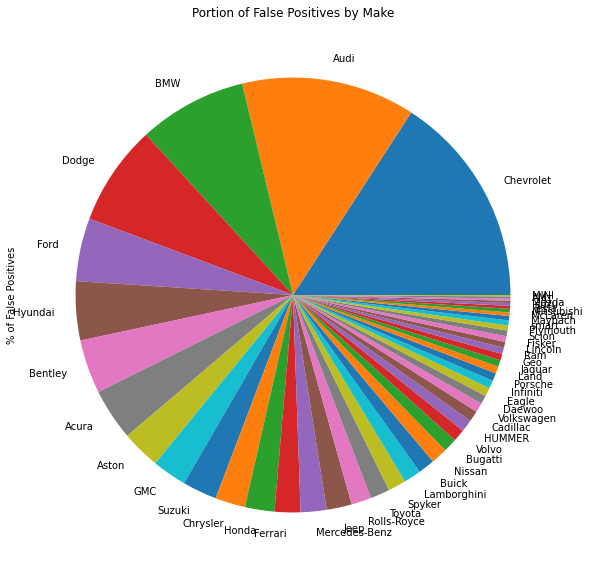

In [173]:
# plot the percentage of misclassifications by make
most_missed_df.plot.pie(y='% of False Positives', figsize=(10, 10), legend=False)
plt.title('Portion of False Positives by Make')

# save the image for presentation
plt.savefig('report_pics/missclassification_by_make.tif', bbox_inches = "tight", dpi=300)

### Observing False Positives Among the Least Precise Classes: Findings
I created a dataframe containing all of the predictions and labels on the test set, then wrote a function to retrieve the count of the classes that were predicted incorrectly for an individual class, and combined these dataframes for all of the classes. The results showed what I expected from earlier exploration, a few of the least precise classes make up larger portions of the total false positives than they should. The Audi S5 Coupe 2012, for example, makes up a __1.39%__ share of all false positives, while the 42 image class represents only __0.52%__ of the test set.  
  
When examining the false positives by make, the picture becomes even more clear. Five makes: Chevrolet, Audi, BMW, Dodge, and Ford, represent half of all false positives. To continue my trend of picking on Audi, there are 580 images of Audis in total, or __7.21%__ of the test data, yet Audis represent __12.91%__ of all false positives.  
  
This investigation has lead me to another hunch, I think that due to the similarity of car models within makes, particularly for makes like Audi, many of these false positives were predicted to be the correct make, but the wrong model or year. This coincides beautifully with something I wanted to do but had not had the time to: predict vehicle makes. I was slightly disappointed that I would not have time to change the labels and file structure of the dataset then train models to predict the makes directly, but I realized in doing the above analysis that I don't need to. If the model often predicts some Audi model when the true label's make is Audi, then it must know something about what an Audi looks like.

### Re-scoring the Model by Make <a class="anchor" id="3"></a>
In my next steps I will re-evaluate the model using vehicle makes as the class labels.

In [28]:
# make a new predictions dataframe for editing
pred_df_make = pred_df.copy()
pred_df_make

,Label,Predicted
0,0,122
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
8036,195,193
8037,195,145
8038,195,195
8039,195,99


In [29]:
# retrieve the class names
names_dict = test_data.class_indices

# invert the name dictionary for reverse lookup
inv_dict = {v: k for k, v in names_dict.items()}

# add duplicate columns to preserve the predicted class numbers
pred_df_make['Label Number'] = pred_df_make['Label']
pred_df_make['Predicted Number'] = pred_df_make['Predicted']

# convert the label number column to class names
pred_df_make = pred_df_make.replace({'Label':inv_dict})
pred_df_make = pred_df_make.replace({'Predicted':inv_dict})

# convert the class names to makes
pred_df_make['Label'] = pred_df_make['Label'].str.split(' ', expand=True).iloc[:, 0]
pred_df_make['Predicted'] = pred_df_make['Predicted'].str.split(' ', expand=True).iloc[:, 0]

# view the modified dataframe
pred_df_make

,Label,Predicted,Label Number,Predicted Number
0,AM,Geo,0,122
1,AM,AM,0,0
2,AM,AM,0,0
3,AM,AM,0,0
4,AM,AM,0,0
...,...,...,...,...
8036,smart,Volvo,195,193
8037,smart,Jeep,195,145
8038,smart,smart,195,195
8039,smart,FIAT,195,99


In [30]:
# some makes contain a space, so their names will not be immediately recognizable
# this could be corrected manually but is not necessary as the first-delineator class names are unique

# this will provied a much needed view of the distribution by make within the data
# this becomes the class distribution for a make-class model
pred_df_make['Label'].value_counts()

Chevrolet        894
Dodge            623
Audi             580
BMW              524
Ford             514
Hyundai          433
Mercedes-Benz    257
Chrysler         256
Acura            240
GMC              235
Bentley          234
Jeep             218
Nissan           170
Suzuki           166
Toyota           164
Ferrari          162
Honda            160
Lamborghini      158
Aston            157
Buick            156
Volkswagen       131
Volvo            129
Cadillac         128
Rolls-Royce      112
Spyker            87
Land              84
HUMMER            82
Bugatti           75
Infiniti          66
FIAT              60
Mitsubishi        47
Jaguar            46
Eagle             46
Daewoo            45
Plymouth          44
AM                44
McLaren           44
Geo               44
Porsche           43
Fisker            43
Ram               41
Scion             41
Isuzu             40
smart             40
Lincoln           39
Tesla             38
Mazda             36
MINI         

In [31]:
# get the number of correct and total predictions
correct_preds = pred_df_make.loc[pred_df_make['Predicted'] == pred_df_make['Label']].shape[0]
total_preds = pred_df_make['Label'].count()

# calculate and print the accuracy
accuracy = correct_preds / total_preds
print(f'The make-class model accuracy is: {accuracy}')

The make-class model accuracy is: 0.8569829623181197


### Re-scoring the Model by Make: Findings
The first component helping me decipher the validity of my hunch came from the make counts within the data shown above. The afformentioned 5 classes: Chevrolet, Audi, BMW, Dodge, and Ford, make up __38.99%__ of the data, but they account for __48.99%__ of the false positives. Disproportionate false positives among these classes is not sufficient proof, however. I re-scored the model using makes as class labels and the accuracy improved by __9.01%__! This shows definitively that there must be more false positives within the original predictions bearing the same make as the true label than false positives with a make that differs from the true label, otherwise the accuracy would have gone down. This also shows that the model is capable of generalizing information from features of individual cars to identify the styles of makes.

### Further Evaluation of the Make-Class Model Predictions<a class="anchor" id="4"></a>
Next I will further evaluate the make-class model predictions by examining the precision values for each class as I did with the original predictions above. 

In [32]:
# set the labels and predictions for the make-class model report 
labels = pred_df_make['Label']
predicted = pred_df_make['Predicted']

# generate the classification report and view it
report = classification_report(labels, predicted)
print(report)

               precision    recall  f1-score   support

           AM       0.93      0.93      0.93        44
        Acura       0.93      0.78      0.85       240
        Aston       0.81      0.87      0.84       157
         Audi       0.87      0.89      0.88       580
          BMW       0.89      0.87      0.88       524
      Bentley       0.87      0.82      0.85       234
      Bugatti       0.92      0.88      0.90        75
        Buick       0.87      0.88      0.87       156
     Cadillac       0.85      0.88      0.87       128
    Chevrolet       0.85      0.82      0.83       894
     Chrysler       0.84      0.85      0.84       256
       Daewoo       0.82      0.73      0.78        45
        Dodge       0.90      0.88      0.89       623
        Eagle       0.83      0.74      0.78        46
         FIAT       0.88      0.95      0.91        60
      Ferrari       0.92      0.89      0.90       162
       Fisker       0.83      0.81      0.82        43
         

In [33]:
# put the classification report into a dataframe
report = classification_report(labels, predicted, output_dict=True)
make_class_report_df = pd.DataFrame(report).transpose()

In [34]:
# drop the aggregated rows as before 
make_class_report_df.drop('weighted avg', inplace=True)
make_class_report_df.drop('macro avg', inplace=True)
make_class_report_df.drop('accuracy', inplace=True)

In [35]:
# print the top ten classes by precision score
make_class_report_df.sort_values(by=['precision'], ascending=False).head(10)

,precision,recall,f1-score,support
Lamborghini,0.978873,0.879747,0.926667,158.0
Land,0.975904,0.964286,0.970060,84.0
MINI,0.971429,0.944444,0.957746,36.0
smart,0.970588,0.825000,0.891892,40.0
HUMMER,0.962025,0.926829,0.944099,82.0
Lincoln,0.939394,0.794872,0.861111,39.0
Jeep,0.938095,0.903670,0.920561,218.0
AM,0.931818,0.931818,0.931818,44.0
Acura,0.925743,0.779167,0.846154,240.0
Ferrari,0.917197,0.888889,0.902821,162.0


In [36]:
# print the bottom ten classes by precision score
make_class_report_df.sort_values(by=['precision']).head(10)

,precision,recall,f1-score,support
Mitsubishi,0.494118,0.893617,0.636364,47.0
Mercedes-Benz,0.760000,0.887160,0.818671,257.0
Mazda,0.767442,0.916667,0.835443,36.0
Jaguar,0.770833,0.804348,0.787234,46.0
Toyota,0.780220,0.865854,0.820809,164.0
Volkswagen,0.781457,0.900763,0.836879,131.0
GMC,0.781893,0.808511,0.794979,235.0
Plymouth,0.787234,0.840909,0.813187,44.0
Porsche,0.800000,0.744186,0.771084,43.0
Tesla,0.809524,0.894737,0.850000,38.0


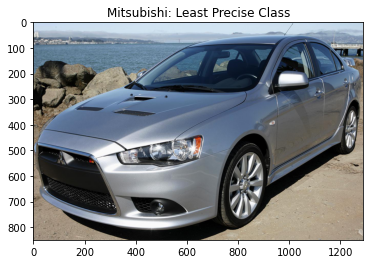

In [41]:
# load and display an image from the lowest precision class
image = plt.imread("data/car_data/car_data/test/Mitsubishi Lancer Sedan 2012/00980.jpg")
plt.title('Mitsubishi: Least Precise Class')
plt.imshow(image)

plt.show()

### Further Evaluation of the Make-Class Model Predictions: Findings
Examination of the model results using vehicle make as the class reveals that not only is the model more accurate as a whole, it has also lowered the spread of precision scores among classes drastically. Previously in the year-make-model-type-class model, the difference between the least precisely predicted class and the most precisely predicted class was __0.72__. In the make-class model evaluation, the same difference calculation between class precision scores is __0.49__, or even lower, __0.22__, if the single least precise outlier is excluded—discussed below. 
  
Examining the classes with lower precision scores, Mitsubishi is a clear outlier in the lowest position, nearly 30 points below the second least precise class Mercedes-Benz. Digging into the data, Mitsubishi has only one model present, and it is the 2012 Lancer, a generic looking sedan. With additional time to work on the dataset I would be sure that more Mitsubishi models are present in the data and I would expect to see the false positives for the class drop dramatically.  
  
Examining the predictions of the model by make has made me curious about the model's ability to predict vehicle types as classes. Just like predictions by make, this is something that I wanted to do since starting the project but had believed I would not have time to complete given the additional training time. I have the framework to complete it without retraining however, and I cannot in good conscience put the project away without having a look. Below I will apply the same methods used above to create make-class predictions, instead creating a list of type-class predictions. My hypothesis this time is that accuracy will improve yet again, this time showing that false positives are being generated in high proportion between predictions and true labels bearing the same vehicle type. 

### Type Label Data Cleaning <a class="anchor" id="5"></a>
The type labels are not as clean as the make labels, and will require some work to make them usable.

In [37]:
# make a new predictions dataframe for editing
pred_df_type = pred_df.copy()
pred_df_type

,Label,Predicted
0,0,122
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
8036,195,193
8037,195,145
8038,195,195
8039,195,99


In [38]:
# retrieve the class names
names_dict = test_data.class_indices

# invert the name dictionary for reverse lookup
inv_dict = {v: k for k, v in names_dict.items()}

# add duplicate columns to preserve the predicted class numbers
pred_df_type['Label Number'] = pred_df_type['Label']
pred_df_type['Predicted Number'] = pred_df_type['Predicted']

# convert the label number column to class names
pred_df_type = pred_df_type.replace({'Label':inv_dict})
pred_df_type = pred_df_type.replace({'Predicted':inv_dict})

In [39]:
# view the type-class distribution
pred_df_type['Label'].str.split(' ', expand=False).str[-2].value_counts()

Sedan           1880
SUV             1418
Coupe           1042
Convertible     1022
Cab              711
Hatchback        549
Van              287
Wagon            250
Minivan          248
SS               117
SRT-8             90
ZR1               46
XKR               46
R                 44
SuperCab          42
Type-S            42
SRT8              39
Z06               37
GS                35
Superleggera      35
IPL               34
Abarth            27
Name: Label, dtype: int64

### Type Label Data Cleaning: Findings
Not all of the labels follow the specified format of "Make Model Type Year" as some have multi-word makes, models, or types, and some class labels contain no type at all. Additionally, for the purpose of classifying by type, some labels need to be combined. For example all types ending in "Cab" or some variation thereof should belong to a class of pickup trucks. Minivans and Vans should also be the same class, though that could easily be reversed for a use case such as marketing data specifically targeting Minivan owners, or conversely commercial Vans.  
  
Because the process of determining type labels requires some human verification (like checking for 2 or 4 doors to label a vehicle as a Coupe or a Sedan), I went through the data directories manually and recorded notes on the classes that generated the faulty labels. I have included my notes on those classes below, and will adress these problem classes to create a clean type-label predictions dataframe. 

_Incorrect Label:_ __Cab__
-ALL Cab --> Pickup

_Incorrect Label:_ __Minivan__
- ALL Minivan --> Van

_Incorrect Label:_ __SS__   
(requires pre-conversion correction due to different classes within label)
- Chevrolet Cobalt SS 2010 --> Coupe
- Chevrolet HHR SS 2010 --> Wagon
- Chevrolet TrailBlazer SS 2009 --> SUV

_Incorrect Label:_ __SRT-8__  
(can be corrected post conversion, all to Sedan)
- Dodge Charger SRT-8 2009 --> Sedan
- Chrystler 300 SRT-8 2010 --> Sedan

_Incorrect Label:_ __ZR1__  
(can be corrected post conversion, all to Coupe)
- Chevrolet Corvette ZR1 2012 --> Coupe

_Incorrect Label:_ __XKR__  
(can be corrected post conversion, all to Coupe)
- Jaguar XK XKR 2012 --> Coupe

_Incorrect Label:_ __R__  
(can be corrected post conversion, all to Coupe)
- Acura Integra Type R 2001 --> Coupe

_Incorrect Label:_ __SuperCab__
- ALL SuperCab --> Pickup

_Incorrect Label:_ __Type-S__  
(can be corrected post conversion, all to Sedan)
- Acura TL Type-S 2008 --> Sedan

_Incorrect Label:_ __SRT8__  
(can be corrected post conversion, all to Coupe)
- Dodge Challenger SRT8 2011 --> Coupe

_Incorrect Label:_ __Z06__  
(can be corrected post conversion, all to Coupe)
- Chevrolet Corvette Ron Fellows Edition Z06 2007 --> Coupe

_Incorrect Label:_ __GS__  
(can be corrected post conversion, all to Sedan)
- Buick Regal GS 2012 --> Sedan

_Incorrect Label:_ __Superleggera__  
(can be corrected post conversion, all to Coupe)
- Lamborghini Gallardo LP 570-4 Superleggera 2012 --> Coupe

_Incorrect Label:_ __IPL__  
(can be corrected post conversion, all to Coupe)
- Infinity G Coupe IPL 2012 --> Coupe

_Incorrect Label:_ __Abarth__  
(can be corrected post conversion, all to Coupe)
- FIAT 500 Abarth 2012 --> Coupe

In [40]:
# pre-conversion corrections to the class format
# Chevrolet Cobalt SS 2010 --> Coupe 
# (X serves as a placeholder for the year because the code counts backwards through space delineators)
pred_df_type.loc[pred_df_type.Label == 'Chevrolet Cobalt SS 2010', 'Label'] = 'Coupe X'
pred_df_type.loc[pred_df_type.Predicted == 'Chevrolet Cobalt SS 2010', 'Predicted'] = 'Coupe X'

# Chevrolet HHR SS 2010 --> Wagon
pred_df_type.loc[pred_df_type.Label == 'Chevrolet HHR SS 2010', 'Label'] = 'Wagon X'
pred_df_type.loc[pred_df_type.Predicted == 'Chevrolet HHR SS 2010', 'Predicted'] = 'Wagon X'

# Chevrolet TrailBlazer SS 2009 --> SUV
# this final correction can be made post-conversion as it will be the only remaining SS label

# convert the class names to makes
pred_df_type['Label'] = pred_df_type['Label'].str.split(' ', expand=False).str[-2]
pred_df_type['Predicted'] = pred_df_type['Predicted'].str.split(' ', expand=False).str[-2]

# view the modified dataframe
pred_df_type

,Label,Predicted,Label Number,Predicted Number
0,SUV,Convertible,0,122
1,SUV,SUV,0,0
2,SUV,SUV,0,0
3,SUV,SUV,0,0
4,SUV,SUV,0,0
...,...,...,...,...
8036,Convertible,Hatchback,195,193
8037,Convertible,SUV,195,145
8038,Convertible,Convertible,195,195
8039,Convertible,Convertible,195,99


In [41]:
# check the type-class distribution again
pred_df_type['Label'].value_counts()

Sedan           1880
SUV             1418
Coupe           1083
Convertible     1022
Cab              711
Hatchback        549
Van              287
Wagon            286
Minivan          248
SRT-8             90
XKR               46
ZR1               46
R                 44
SuperCab          42
Type-S            42
SS                40
SRT8              39
Z06               37
GS                35
Superleggera      35
IPL               34
Abarth            27
Name: Label, dtype: int64

In [42]:
# pre-conversion corrections have changed the count of SS labels from 117 to 40, as expected
# post conversion corrections can now proceed and the final class distribution can be viewed

# define a function to relabel a class in the dataframe when called
def relabel(mislabeled, new_label):
    '''
    Searches for the mislabeled type-class provided and changes it to the new label
    provided for all rows in both predictions and true labels
    
    Parameters
    ----------
    mislabeled: a string with the incorrect label
    new_label: the correct label to replace the mislabelling
    
    Returns
    -------
    ret: none
    
    '''
    # assert types for all parameters
    assert isinstance(mislabeled, str), 'mislabeled must be a string'    
    assert isinstance(new_label, str), 'new_label must be a string' 
    
    # change the labels
    pred_df_type.loc[pred_df_type.Label == mislabeled, 'Label'] = new_label
    pred_df_type.loc[pred_df_type.Predicted == mislabeled, 'Predicted'] = new_label
    
    # print some confirmation output
    print(f'Changed {mislabeled} labels to {new_label}')

In [43]:
# create lists of the incorrect labels and their replacements
mislabeled_list = ['Cab','Minivan','SS','SRT-8','ZR1','XKR','R','SuperCab',
                   'Type-S','SRT8','Z06','GS','Superleggera','IPL','Abarth']
new_label_list = ['Pickup','Van','SUV','Sedan','Coupe','Coupe','Coupe','Pickup',
                  'Sedan','Coupe','Coupe','Sedan','Coupe','Coupe','Coupe']

# place the label lists into a dataframe for verification and view it
verification_list = pd.DataFrame({'Mislabeled': mislabeled_list,
                                  'New Label': new_label_list})

verification_list

,Mislabeled,New Label
0,Cab,Pickup
1,Minivan,Van
2,SS,SUV
3,SRT-8,Sedan
4,ZR1,Coupe
5,XKR,Coupe
6,R,Coupe
7,SuperCab,Pickup
8,Type-S,Sedan
9,SRT8,Coupe


In [44]:
# all replacement labels are correct and the function can be called 
# to replace the incorrect labels
for i in range(0, len(mislabeled_list)):
    relabel(mislabeled_list[i], new_label_list[i])

Changed Cab labels to Pickup
Changed Minivan labels to Van
Changed SS labels to SUV
Changed SRT-8 labels to Sedan
Changed ZR1 labels to Coupe
Changed XKR labels to Coupe
Changed R labels to Coupe
Changed SuperCab labels to Pickup
Changed Type-S labels to Sedan
Changed SRT8 labels to Coupe
Changed Z06 labels to Coupe
Changed GS labels to Sedan
Changed Superleggera labels to Coupe
Changed IPL labels to Coupe
Changed Abarth labels to Coupe


### Evaluation of Type-Class Model Predictions <a class="anchor" id="6"></a>
Below I will evaluate the type-class predictions using the same methods used to evaluate previous predictions.

In [45]:
# check the type-class distribution a final time
pred_df_type['Label'].value_counts()

Sedan          2047
SUV            1458
Coupe          1391
Convertible    1022
Pickup          753
Hatchback       549
Van             535
Wagon           286
Name: Label, dtype: int64

In [116]:
# get the number of correct and total predictions
correct_preds = pred_df_type.loc[pred_df_type['Predicted'] == pred_df_type['Label']].shape[0]
total_preds = pred_df_type['Label'].count()

# calculate and print the accuracy
accuracy = correct_preds / total_preds
print(f'The type-class model accuracy is: {accuracy}')

The type-class model accuracy is: 0.8990175351324462


In [117]:
# set the labels and predictions for the make-class model report 
labels = pred_df_type['Label']
predicted = pred_df_type['Predicted']

# generate the classification report and view it
report = classification_report(labels, predicted)
print(report)

              precision    recall  f1-score   support

 Convertible       0.91      0.86      0.88      1022
       Coupe       0.88      0.83      0.85      1391
   Hatchback       0.82      0.84      0.83       549
      Pickup       0.97      0.97      0.97       753
         SUV       0.95      0.94      0.95      1458
       Sedan       0.87      0.92      0.90      2047
         Van       0.95      0.94      0.95       535
       Wagon       0.82      0.84      0.83       286

    accuracy                           0.90      8041
   macro avg       0.90      0.89      0.89      8041
weighted avg       0.90      0.90      0.90      8041



In [119]:
# put the classification report into a dataframe
report = classification_report(labels, predicted, output_dict=True)
type_class_report_df = pd.DataFrame(report).transpose()

In [120]:
# drop the aggregated rows as before 
type_class_report_df.drop('weighted avg', inplace=True)
type_class_report_df.drop('macro avg', inplace=True)
type_class_report_df.drop('accuracy', inplace=True)

In [121]:
# print the top ten classes by precision score
type_class_report_df.sort_values(by=['precision'], ascending=False)

,precision,recall,f1-score,support
Pickup,0.966931,0.970784,0.968854,753.0
Van,0.952652,0.940187,0.946378,535.0
SUV,0.946355,0.943759,0.945055,1458.0
Convertible,0.908808,0.858121,0.882738,1022.0
Coupe,0.879205,0.826743,0.852167,1391.0
Sedan,0.868966,0.923302,0.895310,2047.0
Hatchback,0.823214,0.839709,0.831380,549.0
Wagon,0.816949,0.842657,0.829604,286.0


### Evaluation of Type-Class Model Predictions: Findings
After converting the predictions to type class labels and re-scoring the model, accuracy improved by another __4.2%__. This confirms my theory that many of the false positives observed within the make-class predictions were from vehicles of the same type. The precision spread has again been lowered to only __0.15__. The predictions are as expected, the model is best at identifying vehicle tpes with unique shapes like Pickups and SUVs, while it is less precisely identifying types with more similar features like Wagons and Hatchbacks.  
  
I find the model's ability to distinguish both makes and types accurately confidence inspiring because those identifications rely upon different things. Chevrolet, for example, contains nearly every type-class within the dataset, yet it was identified by the make-class model with a precision of __0.85__, near the top end among makes. This means the model has learned information independent of the car type that is unique to these brands.   
  
The use case for the type-class predictions is similar to that of the make-class predictions—market data on exactly where hatchbacks are more common, for example, is increadibly useful to automotive manufacturer marketing teams. 

### Conclusion <a class="anchor" id="7"></a>
With the final model trained, I used the predictions on the test set to evaluate the model's viability. Viewing the class-by-class evaluation metrics, most importantly to my proposed use case precision, revealed that some classes produced more than their expected share of false positives. The classes that produced these disproportionate false positives lead me to think that there may be many missclassifications among classes from the same manufacturer. I re-evaluated the model using makes as labels and the accuracy improved, showing not only that my thinking was correct but also adding to the viability of the model for my intended use case. My next hypothesis was that false positives were also being generated in high numbers between vehicles of the same body type, so I applied the same process again the model's evaluation metrics again improved. The final result is that the model can identify exact car models, makes, and body types with accuracy sufficient to gernerate quality market data if deployed on the open road. 